<a href="https://colab.research.google.com/github/drmshyamaladevi/Gradient-Transformer-Self-Attention-U-Net-/blob/main/CrackAUNet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Extra
from IPython.display import clear_output as cls
!pip install tf_explain
cls()

In [ ]:
# Common
import os
import keras
import numpy as np
from glob import glob
from tqdm import tqdm
import tensorflow as tf

# Data
from tensorflow.image import resize
from keras.preprocessing.image import load_img, img_to_array

# Data Viz
import matplotlib.pyplot as plt

# Model
from keras import Sequential
from keras.layers import add
from keras.layers import ReLU
from keras.layers import Input
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import multiply
from keras.layers import MaxPool2D
from keras.layers import LeakyReLU
from keras.layers import concatenate
from keras.layers import UpSampling2D
from keras.layers import Conv2DTranspose
from keras.layers import BatchNormalization
from keras.models import Model, load_model

# Model viz
from tf_explain.core.grad_cam import GradCAM
from tensorflow.keras.utils import plot_model

# Callback
from keras.callbacks import Callback, ModelCheckpoint

In [ ]:
def load_image(path):
    return resize(img_to_array(load_img(path))/255.,(256,256))

def load_data(root_path, trim=None):
    paths = glob(root_path + "/*.jpg")
    if trim is not None:
        paths = paths[:trim]
    images, masks = np.zeros(shape=(len(paths), 256, 256, 3)), np.zeros(shape=(len(paths), 256, 256, 3))
    for i, path in tqdm(enumerate(paths), desc="Loading"):
        images[i] = load_image(path)

        mask_path = path.replace("img","mask")
        masks[i] = load_image(mask_path)
    return images, masks

In [ ]:
images, masks = load_data('/content/drive/My Drive/Crack/img',trim=None)
train_images, train_masks = images[:32], masks[:32]
test_images, test_masks = images[32:], masks[32:]

Loading: 40it [00:21,  1.88it/s]


In [ ]:
def show_image(image, alpha=1, title=None):
    plt.imshow(image, alpha=alpha)
    plt.title(title)
    plt.axis('off')

In [ ]:
def show_mask(image, mask, alpha=0.6):
    show_image(image)
    show_image(mask, alpha=alpha)

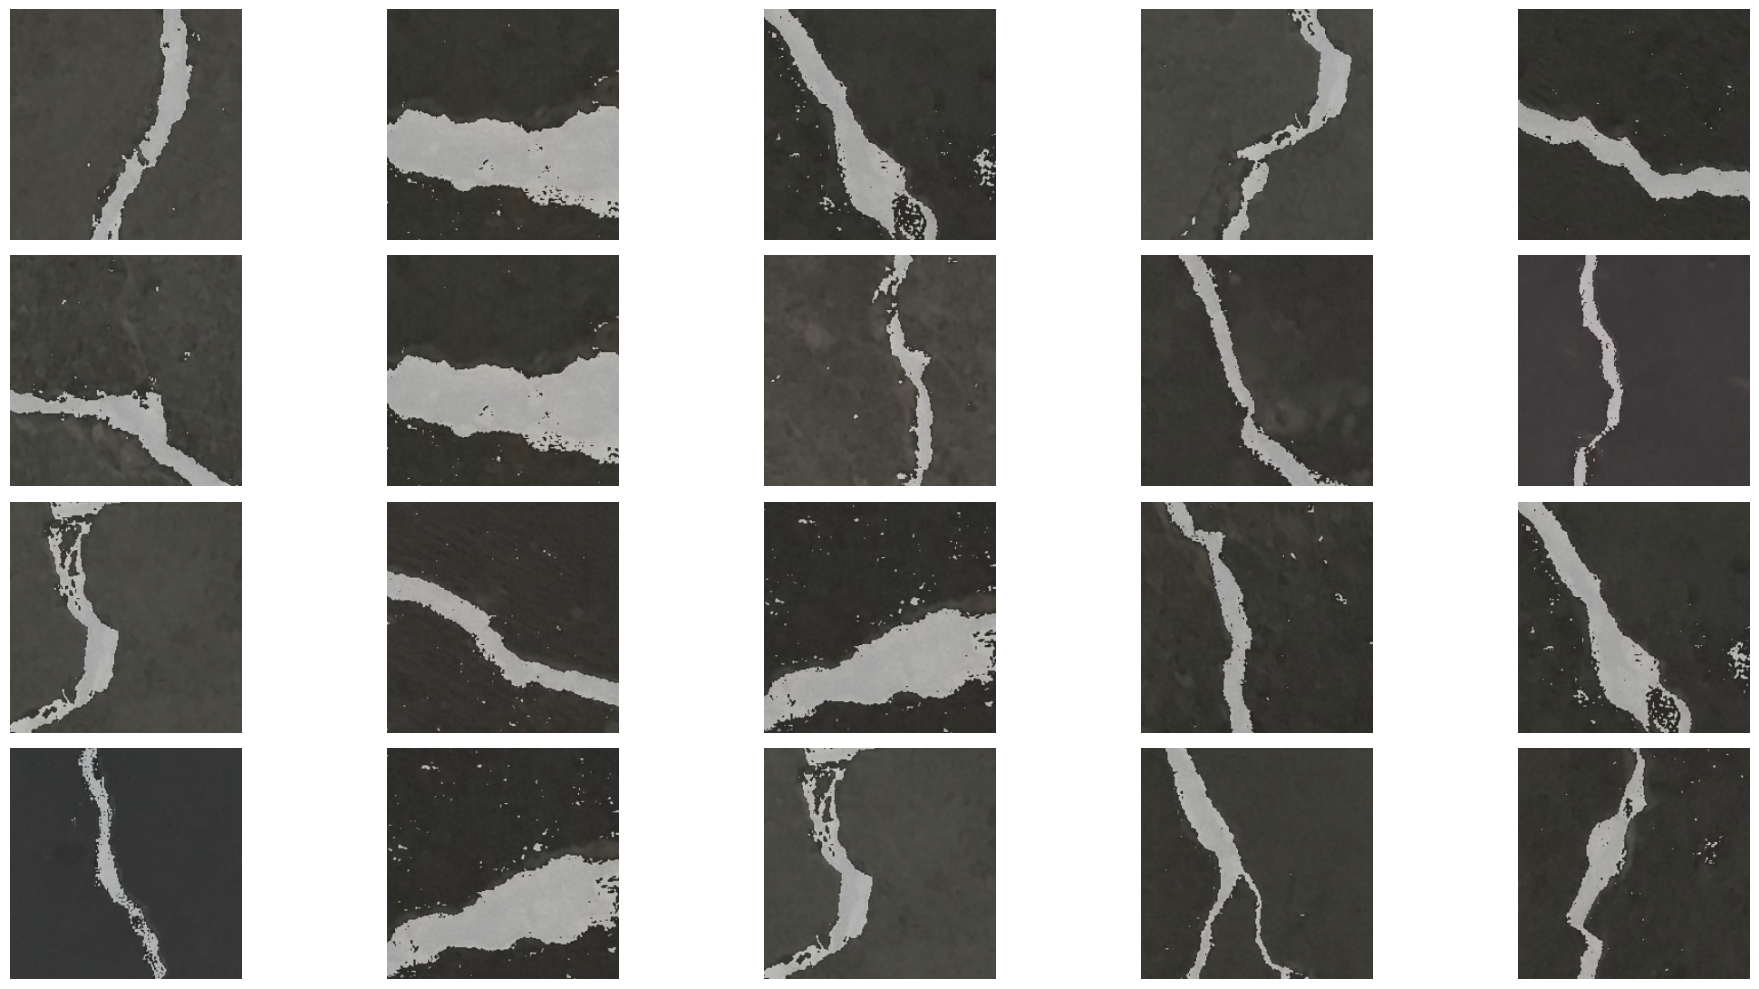

In [ ]:
plt.figure(figsize=(20,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    id = np.random.randint(len(images))
    image = images[id]
    mask = masks[id]
    show_mask(image, mask)
plt.tight_layout()
plt.show()

In [ ]:
class EncoderBlock(keras.layers.Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock,self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.conv1 = Conv2D(self.filters,kernel_size=3,strides=1,padding='same',activation='relu',kernel_initializer='he_normal')
        self.drop = Dropout(rate)
        self.conv2 = Conv2D(self.filters,kernel_size=3,strides=1,padding='same',activation='relu',kernel_initializer='he_normal')
        self.pool = MaxPool2D(pool_size=(2,2))

    def call(self, inputs):
        x = self.drop(self.conv1(inputs))
        x = self.conv2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "rate":self.rate,
            "pooling":self.pooling
        }

In [ ]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.bn = BatchNormalization()
        self.cT = Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer="he_normal")
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        x, skip_x = X
        x = self.bn(x)
        x = self.cT(x)
        x = concatenate([x, skip_x])
        x = self.net(x)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "rate":self.rate,
        }

In [ ]:
class AttentionGate(Layer):

    def __init__(self, filters, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.resample = UpSampling2D()
        self.c = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')

    def call(self, X):
        x, skip_x = X

        x = self.normal(x)  # normally pass the previous decoder inputs through a convolutional layer.
        skip = self.down(skip_x)  # downsample the Skip connections as they are larger in size.

        x = add([x, skip])  # add both the skip connections and the previous decoder outputs.
        x = self.c(x)      # pass it through a convolutional layer that is responsible for learning the importance factors.
        x = self.resample(x)  # upsample the image.

        skip_x = multiply([x, skip_x])  # Apply the learnt importance factors.
        return skip_x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters
        }

In [ ]:
# Inputs
unet_input = Input(shape=(256,256,3), name="UnetInput")

# Encoder - Downsampling Phase
p1, c1 = EncoderBlock(64, 0.1, name="Encoder1")(unet_input)
p2, c2 = EncoderBlock(128, 0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(256, 0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(512, 0.2, name="Encoder4")(p3)

# Encoding - Latent Representation
e = EncoderBlock(512, 0.3, pooling=False, name="Encoding")(p4)

#  Attention plus decoder network.
a1 = AttentionGate(512,name="Attention1")([e, c4])
d1 = DecoderBlock(512,0.2,name="Decoder1")([e, a1])

a2 = AttentionGate(256,name="Attention2")([d1, c3])
d2 = DecoderBlock(256,0.2,name="Decoder2")([d1, a2])

a3 = AttentionGate(128,name="Attention3")([d2, c2])
d3 = DecoderBlock(128,0.1,name="Decoder3")([d2, a3])

a4 = AttentionGate(64,name="Attention4")([d3, c1])
d4 = DecoderBlock(64,0.1,name="Decoder4")([d3, a4])

unet_out = Conv2D(3, kernel_size=3, padding='same', activation='sigmoid', name="UNetOut")(d4)

# Model
aunet = Model(
    inputs=unet_input,
    outputs=unet_out,
    name="Unet"
)

# Compiling
aunet.compile(
    loss='binary_crossentropy',
    optimizer='adam'
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'Encoding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'encoder_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'encoder_block_1', however the layer does n